# Examples showing importance of zero-stability


[AMath 586, Spring Quarter 2019](http://staff.washington.edu/rjl/classes/am586s2019/) at the University of Washington. For other notebooks, see [Index.ipynb](Index.ipynb) or the [Index of all notebooks on Github](https://github.com/rjleveque/amath586s2019/blob/master/notebooks/Index.ipynb).

In this notebook we test 3 methods on a the simple test problem $u'(t) = u(t)$ with $u(0)=1$, for which the exact solution is $u(t) = e^t$, and examine how the computed solution and error behave as we decrease the time step.

For Forward Euler and Midpoint, we observe that the error grows with time, but over a fixed time interval it converges to zero with $\Delta t = k$.  These methods are not only consistent but also zero-stable.   Finally we test a method that is consistent but fails to be zero-stable and see that the method does not converge.

In [1]:
%matplotlib inline

In this notebook we use some widgets from the [ipywidgets](https://ipywidgets.readthedocs.io/en/stable/) module:

In [2]:
from pylab import *
from ipywidgets import interact, IntSlider

Define a function to make plots to use with each method tested:

In [3]:
def make_plots(t,U,method_name):
    Utrue = exp(t)
    E = U - Utrue  # error
    Emax = abs(E).max()
    dt = t[1] - t[0]
        
    figure(figsize=(11,5))
    subplot(1,2,1)
    plot(t, Utrue, 'k-', label='True solution')
    plot(t, U, 'b-o', label='Computed')
    legend(loc='upper left')
    ylim(0,10)
    title('%s with dt = %.6f' % (method_name,dt))
    subplot(1,2,2)
    plot(t, E, 'r-o')
    title('Maximum |Error| = %.6f' % Emax)

## Forward Euler

First we test the Forward Euler method.

In [4]:
def ForwardEuler(nsteps):
    t0 = 0.;  tfinal = 2.
    t = linspace(t0, tfinal, nsteps+1)
    dt = t[1] - t[0]
    
    # Array for computed solution
    # give it two rows so each column is solution at one time,
    # since function f(u) = A*u is matrix-vector multiplication
    
    U = empty(nsteps+1) 
    U.fill(nan)
    U[0] = 1.  # initial value
    for n in range(0,nsteps):
        U[n+1] = U[n] + dt * U[n]
        
    make_plots(t,U,'Forward Euler')

If you call this with different values of `nsteps` you should see that the solution converges as `nsteps` increases.

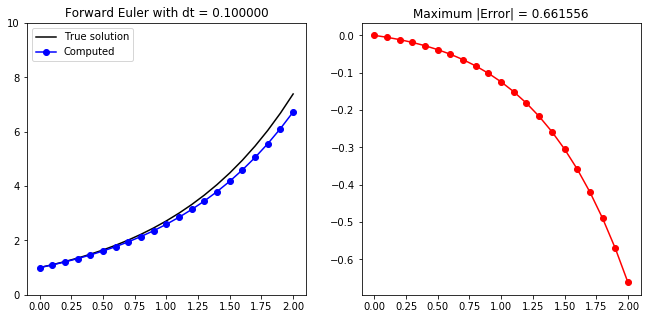

In [5]:
ForwardEuler(20)

This can be simplified with a widget that allows easily changing `nsteps` over a suitable range:

In [6]:
interact(ForwardEuler, nsteps=IntSlider(min=5,max=25,step=5,value=5));

interactive(children=(IntSlider(value=5, description='nsteps', max=25, min=5, step=5), Output()), _dom_classes…

Note that the absolute value of the error grows exponentially in time. Nonetheless, over any fixed time interval such as the $0 \leq t \leq 2$ used here, the error decays to zero over the entire interval as `nsteps` grows (i.e. as $\Delta t \rightarrow 0$).

## Midpoint method

Recall that the 2-point midpoint method $U^{n+2} = U^n + 2 k f(U^{n+1})$ is second order accurate.  Here's an implementation on the test problem $u' = u$:

In [7]:
def Midpoint(nsteps):
    t0 = 0.;  tfinal = 2.
    t = linspace(t0, tfinal, nsteps+1)
    dt = t[1] - t[0]
    
    U = empty(nsteps+1) 
    U.fill(nan)
    U[0] = 1.       # initial value
    U[1] = exp(dt)  # exact solution at t_1
    
    for n in range(0,nsteps-1):
        U[n+2] = U[n] + 2*dt * U[n+1]
        
    make_plots(t,U,'Midpoint')

Since Midpoint is also zero-stable, we see convergence as we increase `nsteps`.  The error still grows exponentially with time but with a multiplicative constant that goes to zero like $\Delta t^2$:

In [8]:
interact(Midpoint, nsteps=IntSlider(min=5,max=25,step=5,value=5));

interactive(children=(IntSlider(value=5, description='nsteps', max=25, min=5, step=5), Output()), _dom_classes…

## An exponentially bad method

Now consider the method given in Example 6.2 on page 143 of the text,
$$
U^{n+2} - 3U^{n+1} + 2U^n = -k f(U^n).
$$
This 2-step linear multistep method is formally first order accurate, with trunction error $\tau^n = \frac 1 2 k u''(t_n) + O(k^2)$, and hence is *consistent.*  

Here's an implementation:

In [9]:
def ExpBadMethod(nsteps):
    t0 = 0.;  tfinal = 2.
    t = linspace(t0, tfinal, nsteps+1)
    dt = t[1] - t[0]
    
    # Array for computed solution
    # give it two rows so each column is solution at one time,
    # since function f(u) = A*u is matrix-vector multiplication
    
    U = empty(nsteps+1) 
    U.fill(nan)
    U[0] = 1.       # initial value
    U[1] = exp(dt)  # exact solution at t_1
    
    for n in range(0,nsteps-1):
        U[n+2] = 3*U[n+1] - 2*U[n] - dt * U[n]
        
    make_plots(t,U,'Exponentially Bad Method')

Although the method is consistent However, it **fails to be zero-stable**.  As a result, increasing `nsteps` does not lead to better results.

In [10]:
interact(ExpBadMethod, nsteps=IntSlider(min=5,max=25,step=5,value=5));

interactive(children=(IntSlider(value=5, description='nsteps', max=25, min=5, step=5), Output()), _dom_classes…

Note that the error actually looks better for the first few time steps as $k$ is decreased.  But now the error grows exponentially **in the number of steps taken**.  This is very different from growing expoentially in time, since it means we do not converge as we decrease the time step over a fixed time interval, in which case `nsteps` grows.

## A linearly bad method

Now consider the method of Example 6.4 in the book,
$$
U^{n+2} - 2U^{n+1} + U^n = -\frac 1 2 k (f(U^{n+2}) - f(U^n)).
$$
This is an implicit method, but for $f(u) = u$ we can easily solve of 
$$
U^{n+2} = \left(2U^{n+1} - U^n -\frac 1 2 k U^n\right) / (1 - k/2).
$$

Here it is implemented using $U^1 = \exp(k)$ as before...

In [11]:
def LinearlyBadMethod(nsteps):
    t0 = 0.;  tfinal = 2.
    t = linspace(t0, tfinal, nsteps+1)
    dt = t[1] - t[0]
    
    # Array for computed solution
    # give it two rows so each column is solution at one time,
    # since function f(u) = A*u is matrix-vector multiplication
    
    U = empty(nsteps+1) 
    U.fill(nan)
    U[0] = 1.       # initial value
    U[1] = exp(dt)  # exact solution at t_1
    
    for n in range(0,nsteps-1):
        U[n+2] = (2*U[n+1] - U[n] - 0.5*dt * U[n]) / (1 - 0.5*dt)
        
    make_plots(t,U,'Linearly Bad Method')

In [12]:
interact(LinearlyBadMethod, nsteps=IntSlider(min=5,max=25,step=5,value=5));

interactive(children=(IntSlider(value=5, description='nsteps', max=25, min=5, step=5), Output()), _dom_classes…

This seems to be converging fine.  But recall that to be *convergent* the method has to converge for any choice of starting data satisfying $U^1 \rightarrow \eta = 1$ as $k \rightarrow 0$.  Here's what happens if we choose $U^1 = 1 + k/2$:

In [13]:
def LinearlyBadMethod(nsteps):
    t0 = 0.;  tfinal = 2.
    t = linspace(t0, tfinal, nsteps+1)
    dt = t[1] - t[0]
    
    # Array for computed solution
    # give it two rows so each column is solution at one time,
    # since function f(u) = A*u is matrix-vector multiplication
    
    U = empty(nsteps+1) 
    U.fill(nan)
    U[0] = 1.       # initial value
    U[1] = 1. + 0.5*dt #exp(dt)  # exact solution at t_1
    
    for n in range(0,nsteps-1):
        U[n+2] = (2*U[n+1] - U[n] - 0.5*dt * U[n]) / (1 - 0.5*dt)
        
    make_plots(t,U,'Linearly Bad Method')

In [14]:
interact(LinearlyBadMethod, nsteps=IntSlider(min=5,max=25,step=5,value=5));

interactive(children=(IntSlider(value=5, description='nsteps', max=25, min=5, step=5), Output()), _dom_classes…

In this case the method seems to converge **to the wrong function** as we reduce $k$.  Note that the error now grows linearly with $t$, not exponentially, but still in a way that does not diminish with $k$ and so the method is **not convergent.** This method also fails to be zero-stable.  See the text for more discussion.

Can you figure out what function this converges to?